## Name and ID

Hannah Doherty, ID:1367980

## HW03 Code


You will complete the following notebook, as described in the PDF for Homework 03 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.


Please report any questions to the [class Piazza page](piazza.com/tufts/spring2021/comp135/home).

### Import required libraries

In [14]:
import os
import numpy as np
import pandas as pd

# imports and setup
from numpy.random import default_rng

from sklearn.datasets import make_classification, load_digits
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.metrics import roc_curve, roc_auc_score, log_loss, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import minmax_scale, PolynomialFeatures

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
np.set_printoptions(suppress=True, precision=3)
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter('ignore', category=ConvergenceWarning)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

warnings.simplefilter(action='ignore', category=FutureWarning)

Cancer-Risk Screening

### 1: Compute true/false positives/negatives.

Complete the following code.

In [2]:
def calc_TP_TN_FP_FN(ytrue_N, yhat_N):
    TP = 0.0
    TN = 0.0
    FP = 0.0
    FN = 0.0
    i=int(0)
    j=int(0)
    ''' Compute counts of four possible outcomes of a binary classifier for evaluation.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yhat_N : 1D array of floats
        Each entry represents a predicted binary value (either 0 or 1).
        One entry per example in current dataset.
        Needs to be same size as ytrue_N.
    '''
    #print(f"i: {i}")
    #print(f"j: {j}")
    #print(f"ytrue_N: {ytrue_N}")
    #print(f"yhat_N: {yhat_N}")
    #print(f"type(ytrue_N[i]): {type(ytrue_N[i])}")
    #print(f"ytrue_N[0] == False: {ytrue_N[i]==False}")
    for i in range(len(ytrue_N)):
        #print(f"i: {i}")
        #print(f"type(i): {type(i)}")
        for j in range(len(yhat_N)):
            #print(f"j: {j}")
            if i==j:
                if ytrue_N[i] == False:
                    if int(ytrue_N[i]) == int(yhat_N[j]):
                        TN +=1
                        i +=1
                        j +=1
                    else:
                        FP +=1
                        i +=1
                        j +=1
                else: #if ytrue == 1
                    if ytrue_N[i]==yhat_N[j]: #check if TP
                        TP +=1
                        i +=1
                        j +=1
                    else:
                        FN +=1
                        i +=1
                        j +=1
            else:
                i +=1
                j +=1
        
    '''
    Returns
    -------
    TP : float
        Number of true positives
    TN : float
        Number of true negatives
    FP : float
        Number of false positives
    FN : float
        Number of false negatives
    '''

    return TP, TN, FP, FN

In [3]:
all0 = np.zeros(10)
all1 = np.ones(10)
calc_TP_TN_FP_FN(all0, all1)

(0.0, 0.0, 10.0, 0.0)

### Supplied functions for later use

***Do not*** edit the following functions.  They are already complete, and will be used in your later code.

In [7]:
def calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute performance metrics for a given probabilistic classifier and threshold
    '''
    tp, tn, fp, fn = calc_TP_TN_FP_FN(ytrue_N, yproba1_N >= thresh)
    ## Compute ACC, TPR, TNR, etc.
    acc = (tp + tn) / float(tp + tn + fp + fn + 1e-10)
    tpr = tp / float(tp + fn + 1e-10)
    tnr = tn / float(fp + tn + 1e-10)
    ppv = tp / float(tp + fp + 1e-10)
    npv = tn / float(tn + fn + 1e-10)
    
    return acc, tpr, tnr, ppv, npv

def print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Pretty print perf. metrics for a given probabilistic classifier and threshold
    '''
    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
    
    ## Pretty print the results
    print("%.3f ACC" % acc)
    print("%.3f TPR" % tpr)
    print("%.3f TNR" % tnr)
    print("%.3f PPV" % ppv)
    print("%.3f NPV" % npv)

In [15]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

In [9]:
def compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N, thresh_grid=None):
    ''' Compute common binary classifier performance metrics across many thresholds
    
    If no array of thresholds is provided, will use all 'unique' values
    in the yproba1_N array to define all possible thresholds with different performance.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset

    Returns
    -------
    thresh_grid : 1D array of floats
        One entry for each possible threshold
    perf_dict : dict, with key, value pairs:
        * 'acc' : 1D array of accuracy values (one per threshold)
        * 'ppv' : 1D array of positive predictive values (one per threshold)
        * 'npv' : 1D array of negative predictive values (one per threshold)
        * 'tpr' : 1D array of true positive rates (one per threshold)
        * 'tnr' : 1D array of true negative rates (one per threshold)
    '''
    if thresh_grid is None:
        bin_edges = np.linspace(0, 1.001, 21)
        thresh_grid = np.sort(np.hstack([bin_edges, np.unique(yproba1_N)]))
    tpr_grid = np.zeros_like(thresh_grid)
    tnr_grid = np.zeros_like(thresh_grid)
    ppv_grid = np.zeros_like(thresh_grid)
    npv_grid = np.zeros_like(thresh_grid)
    acc_grid = np.zeros_like(thresh_grid)
    for tt, thresh in enumerate(thresh_grid):
        # Apply specific threshold to convert probas into hard binary values (0 or 1)
        # Then count number of true positives, true negatives, etc.
        # Then compute metrics like accuracy and true positive rate
        acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
        acc_grid[tt] = acc
        tpr_grid[tt] = tpr
        tnr_grid[tt] = tnr
        ppv_grid[tt] = ppv
        npv_grid[tt] = npv
    return thresh_grid, dict(
        acc=acc_grid,
        tpr=tpr_grid,
        tnr=tnr_grid,
        ppv=ppv_grid,
        npv=npv_grid)

def make_plot_perf_vs_threshold(ytrue_N, yproba1_N, bin_edges=np.linspace(0, 1, 21)):
    ''' Make pretty plot of binary classifier performance as threshold increases
    
    Produces a plot with 3 rows:
    * top row: hist of predicted probabilities for negative examples (shaded red)
    * middle row: histogram of predicted probabilities for positive examples (shaded blue)
    * bottom row: line plots of metrics that require hard decisions (ACC, TPR, TNR, etc.)
    
    The two histograms are as follows:
    * The first (red) shows the number of class-0 entries, grouped by 
      the probabilities assigned by the predictor (yproba1_N).
    * The second (blue) shows the number of class-1 entries, grouped by
      the probabilities assigned by the predictor (yproba1_N).
    
    A "perfect" classifier would assign everything in class 0 the probability 0.0, 
    and everything in class 1 the probability 1.0, and the histograms would look 
    like one big pile of 150 items at 0.0, and then 25 items at 1.0.  
    
    You can actually see what this would look like by calling:
        make_plot_perf_vs_threshold(y_va_N, y_va_N)
    
    Note that we of course don't expect perfect (0.0/1.0) predictions, but we can 
    still get a "perfect" probabilistic classifier if we have a threshold point T 
    where all the 0-class stuff from the first histogram is below T, and all the 
    1-class stuff from the second one is at or above T.  Of course, we probably 
    can't get that either, since complex data may not be linearly separable at all, 
    but that's the goal.
    '''
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
    sns.distplot(
        yproba1_N[ytrue_N == 0],
        color='r', bins=bin_edges, kde=False, rug=True, ax=axes[0]);
    sns.distplot(
        yproba1_N[ytrue_N == 1],
        color='b', bins=bin_edges, kde=False, rug=True, ax=axes[1]);

    thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N)
    axes[2].plot(thresh_grid, perf_grid['acc'], 'k-', label='accuracy')
    axes[2].plot(thresh_grid, perf_grid['tpr'], 'b-', label='TPR (recall/sensitivity)')
    axes[2].plot(thresh_grid, perf_grid['tnr'], 'g-', label='TNR (specificity)')
    axes[2].plot(thresh_grid, perf_grid['ppv'], 'c-', label='PPV (precision)')
    axes[2].plot(thresh_grid, perf_grid['npv'], 'm-', label='NPV')
    
    axes[2].legend()
    axes[2].set_ylim([0, 1])

### Load the dataset.

The following should ***not*** be modified.  After it runs, the various arrays it creates will contain the 2- or 3-feature input datasets.

In [10]:
x_tr = np.loadtxt('x_train.csv', delimiter=',', skiprows=1)
y_tr = np.loadtxt('y_train.csv', delimiter=',', skiprows=1)
x_te = np.loadtxt('x_test.csv', delimiter=',', skiprows=1)

In [33]:
model = LogisticRegression(solver='liblinear',C=1, max_iter=10_000)

#TRAINING: fit and predict
model.fit(x_tr, y_tr)
y_prob_tr = model.predict_proba(x_tr)[:,1]
loss_tr = log_loss(y_tr, y_prob_tr)
score_tr = model.score(x_tr, y_tr)

In [11]:
k = 5
kfold = KFold(n_splits=k, shuffle = True, random_state = 5)

loss_list_tr_final2 = list()
score_list_tr_final2 = list()
loss_list_te_final2 = list()
score_list_te_final2 = list()

loss_list_tr = list()
score_list_tr = list()
loss_list_te = list()
score_list_te = list()

model = LogisticRegression(solver='liblinear',C=1, max_iter=10_000)
for train_idx, test_idx in kfold.split(x_tr):
    X_train, X_test = x_tr[train_idx,:], x_tr[test_idx,:],
    y_train, y_test = y_tr[train_idx], y_tr[test_idx]
    #TRAINING: fit and predict
    model.fit(X_train, y_train)
    y_prob_tr = model.predict_proba(X_train)[:,1]
    loss_tr = log_loss(y_train, y_prob_tr)
    loss_list_tr.append(loss_tr)
    score_tr = model.score(X_train, y_train) 
    score_list_tr.append(score_tr)
    #test stuff now
    y_prob_te = model.predict_proba(X_test)[:,1]
    loss_te = log_loss(y_test, y_prob_te)
    loss_list_te.append(loss_te)
    score_te = model.score(X_test, y_test)
    score_list_te.append(score_te)
loss_list_tr_final2.append(np.mean(loss_list_tr))
loss_list_te_final2.append(np.mean(loss_list_te))
score_list_tr_final2.append(np.mean(score_list_tr))
score_list_te_final2.append(np.mean(score_list_te))

In [12]:
TP,TN,FP,FN = calc_TP_TN_FP_FN(y_test, y_prob_te)

In [16]:
best_thr = 0.5

print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")
# TODO: print(calc_confusion_matrix_for_threshold(...))
cm_df_3 = calc_confusion_matrix_for_threshold(y_test, y_prob_te, thresh=0.5)
print(cm_df_3)
print("")
# TODO: print(print_perf_metrics_for_threshold(...))
print(print_perf_metrics_for_threshold(y_test, y_prob_te, thresh=0.5))

Chosen best thr = 0.5000

ON THE TEST SET:
Predicted     0     1
True                 
0          1194    43
1            51  1112

0.961 ACC
0.956 TPR
0.965 TNR
0.963 PPV
0.959 NPV
None


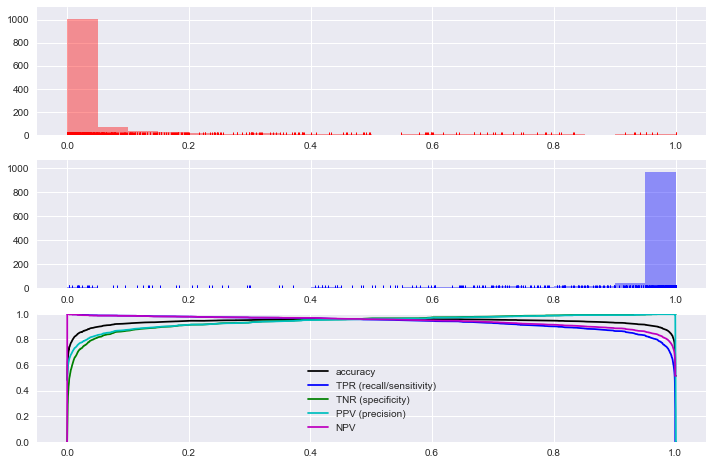

In [17]:
make_plot_perf_vs_threshold(y_test, y_prob_te)
'''
    Produces a plot with 3 rows:
    * top row: hist of predicted probabilities for negative examples (shaded red)
    * middle row: histogram of predicted probabilities for positive examples (shaded blue)
    * bottom row: line plots of metrics that require hard decisions (ACC, TPR, TNR, etc.)
    
    The two histograms are as follows:
    * The first (red) shows the number of class-0 entries, grouped by 
      the probabilities assigned by the predictor (yproba1_N).
    * The second (blue) shows the number of class-1 entries, grouped by
      the probabilities assigned by the predictor (yproba1_N).
'''

### 4: Logistic Regression

#### (a) Create a set of `LogisticRegression` models.

Each model will use a different control parameter, `C`, and each will be fit to 2-feature data.  Probabilistic predictions will be made on both training set and validation set inputs, and logistic-loss for each will be recorded.

#### (c) Model fitting with 3-feature data

Repeat the model generation from **1.4 (a)**, using the full 3-feature data.

In [19]:
# TODO like 1.4 (a), but with 3 features
loss_list_tr3 = list()
loss_list_va3 = list()

best_c3 = 0
val_best_c3 = 0
#print(x_va_N2)
# TODO fit, predict_proba, and evaluate logistic loss    
# Record the best model here
C_grid3 = np.logspace(-9, 6, 31)

for C in range(len(C_grid3)):
    #build and evaluate model for each value C
    model3 = sklearn.linear_model.LogisticRegression(solver='liblinear',C=C_grid3[C])
    #TRAINING: fit and predict
    model3.fit(x_tr_M3, y_tr_M)
    y_prob_tr3 = model3.predict_proba(x_tr_M3)
    loss_tr3 = sklearn.metrics.log_loss(y_tr_M, y_prob_tr3)
    loss_list_tr3.append(loss_tr3)
    #VALIDATION: fit and predict
    #model_va = sklearn.linear_model.LogisticRegression(solver='liblinear',C=C_grid[C])
    y_prob_va3 = model3.predict_proba(x_va_N3)
    loss_va3 = sklearn.metrics.log_loss(y_va_N, y_prob_va3)
    loss_list_va3.append(loss_va3)
    #use training to train adn then fit and predict. Then do same for validation
    if C==0:
        #print(C)
        best_c3 = C
        #print(f"best_c at 0: {best_c} with {loss_list[best_c]}")
    elif C>0:
        if loss_list_va3[best_c3] <= loss_list_va3[C]:
            best_c3 = best_c3
            #print(f"best_c if old is better: {best_c} with {loss_list[best_c]}")
        else:
            best_c3 = C
            #print(f"best_c if new is better: {best_c} with {loss_list[best_c]}")

#print(loss_list_va3)
best_c3_notindex =0
best_c3_notindex = C_grid3[best_c3]
val_best_c3 = loss_list_va3[best_c3]

#### Plot the performance of the predictions made by the best 3-valued classifier on the validation set.

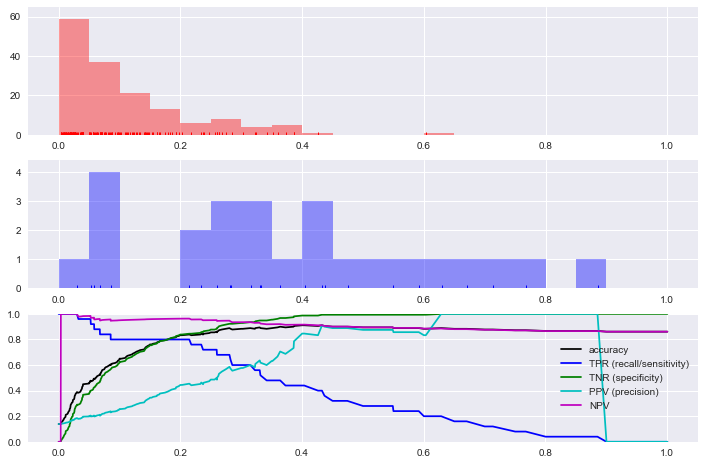

In [21]:
# TODO call make_plot_perf_vs_threshold(...)
# TODO call make_plot_perf_vs_threshold(...)
model3 = sklearn.linear_model.LogisticRegression(solver='liblinear',C=best_c3_notindex)
model3.fit(x_tr_M3, y_tr_M)
y_prob_va3 = model3.predict_proba(x_va_N3)[:,1] #make y_prob for validation and rename
#score = model.score(x_va_N2, y_va_N)
#loss = sklearn.metrics.log_loss(y_va_N, y_prob)

#line below broken
make_plot_perf_vs_threshold(y_va_N, y_prob_va3)

### 5: ROC Curves

These curves allow us to compare model performance in terms of trade-offs between false positive and true positive results.

#### (a) Plot ROC curves on the validation set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

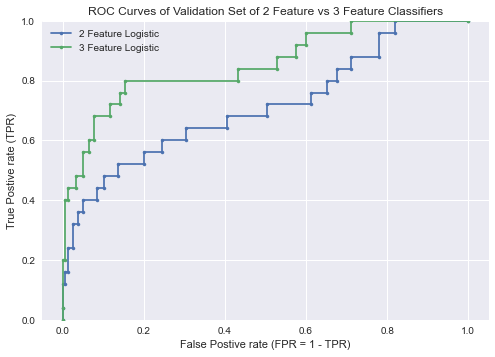

In [22]:
# TODO something like: fpr, tpr, thr = sklearn.metrics.roc_curve(...)
#3rd feature makes it more accurate

fpr, tpr, thr = sklearn.metrics.roc_curve(y_va_N, y_prob_va)
fpr3, tpr3, thr3 = sklearn.metrics.roc_curve(y_va_N, y_prob_va3)

plt.plot(fpr, tpr, marker='.', label='2 Feature Logistic')
plt.plot(fpr3, tpr3, marker='.', label='3 Feature Logistic')
plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");
plt.title('ROC Curves of Validation Set of 2 Feature vs 3 Feature Classifiers')
plt.legend();


#### (b) Plot ROC curves on the test set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

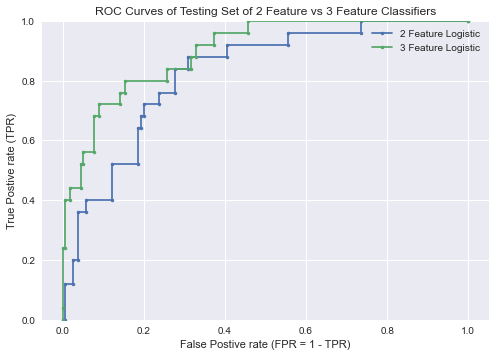

In [23]:
# TODO something like: fpr, tpr, thr = sklearn.metrics.roc_curve(...)

model = sklearn.linear_model.LogisticRegression(solver='liblinear',C=best_c)
model.fit(x_tr_M2, y_tr_M)
y_prob_te = model.predict_proba(x_te_N2)[:,1]

model3 = sklearn.linear_model.LogisticRegression(solver='liblinear',C=best_c3_notindex)
model3.fit(x_tr_M3, y_tr_M)
y_prob_te3 = model3.predict_proba(x_te_N3)[:,1]

fpr_te, tpr_te, thr_te = sklearn.metrics.roc_curve(y_te_N, y_prob_te)
fpr_te3, tpr_te3, thr_te3 = sklearn.metrics.roc_curve(y_te_N, y_prob_te3)

plt.plot(fpr_te, tpr_te, marker='.', label='2 Feature Logistic')
plt.plot(fpr_te3, tpr_te3, marker='.', label='3 Feature Logistic')
plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");
plt.title('ROC Curves of Testing Set of 2 Feature vs 3 Feature Classifiers')
plt.legend();


#### (c) Analyze the results shown in both the above plots, to compare classifier performance.

**Answer**: When comparing the two models over both data sets, we see that the 3 feature logistic always dominates the 2 feature logistic when it comes to the testing set as well as the validation set. This makes sense because increasing the features is a method to better capture the data and decreasing the error which would increase the area under the ROC curve. In the Testing set ROC curve, we see that there is a small area under the curves where the 2 feature logistic beats out the 3 feature logistic. 

### 6: Selecting a decision threshold

#### (a) Using default 0.5 threshold. 

Generate a confusion matrix for the best 3-feature logistic model on the test set, using threshold 0.5.

In [24]:
best_thr = 0.5

print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")
# TODO: print(calc_confusion_matrix_for_threshold(...))
cm_df_3 = calc_confusion_matrix_for_threshold(y_te_N, y_prob_te3, thresh=0.5)
print(cm_df_3)
print("")
# TODO: print(print_perf_metrics_for_threshold(...))
print(print_perf_metrics_for_threshold(y_te_N, y_prob_te3, thresh=0.5))


Chosen best thr = 0.5000

ON THE TEST SET:
Predicted    0   1
True              
0          152   3
1           15  10

0.900 ACC
0.400 TPR
0.981 TNR
0.769 PPV
0.910 NPV
None


#### (b) Pick a threshold to maximize TPR, while ensuring PPV >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [25]:
# TODO thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(...)
thresh_grid3, perf_grid3 = compute_perf_metrics_across_thresholds(y_va_N, y_prob_va3)

# TODO Find threshold that makes validation set TPR as large as possible, 
# while satisfying PPV >= 0.98

max_tpr = 0
max_index = 0
max_thresh = 0
#print(perf_grid3["tpr"])
for i in range(len(perf_grid3["ppv"])):
    if perf_grid3["ppv"][i] >= .98:
        max_tpr = max(perf_grid3["tpr"][i],max_tpr)
        if max_tpr == perf_grid3["tpr"][i]:
            max_index = i
    max_thresh = thresh_grid3[max_index]
        
        
print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % max_thresh)
print("")
print("ON THE TEST SET:")
# TODO: print(calc_confusion_matrix_for_threshold(...))
print(calc_confusion_matrix_for_threshold(y_te_N, y_prob_te3, thresh=max_thresh))
print("")
# TODO: print(print_perf_metrics_for_threshold(...))
print(print_perf_metrics_for_threshold(y_te_N, y_prob_te3, thresh=max_thresh))

ON THE VALIDATION SET:
Chosen best thr = 0.6290

ON THE TEST SET:
Predicted    0  1
True             
0          155  0
1           20  5

0.889 ACC
0.200 TPR
1.000 TNR
1.000 PPV
0.886 NPV
None


#### (c) Pick a threshold to maximize PPV, while ensuring TPR >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [26]:
# TODO thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(...)
thresh_grid3, perf_grid3 = compute_perf_metrics_across_thresholds(y_va_N, y_prob_va3)
# TODO Find threshold that makes validation set PPV as large as possible, 
# while satisfying TPR >= 0.98

max_tpr_c = 0
max_index_c = 0
max_thresh_c = 0
#print(perf_grid3["tpr"])
for k in range(len(perf_grid3["tpr"])):
    if perf_grid3["tpr"][k] >= .98:
        max_tpr_c = max(perf_grid3["ppv"][k],max_tpr_c)
        if max_tpr_c == perf_grid3["ppv"][k]:
            max_index_c = k
    max_thresh_c = thresh_grid3[max_index_c]

print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % max_thresh_c) # TODO
print("")
print("ON THE TEST SET:")
# TODO: print(calc_confusion_matrix_for_threshold(...))
print(calc_confusion_matrix_for_threshold(y_te_N, y_prob_te3, thresh=max_thresh_c))
print("")
# TODO: print(print_perf_metrics_for_threshold(...))
print(print_perf_metrics_for_threshold(y_te_N, y_prob_te3, thresh=max_thresh_c))

ON THE VALIDATION SET:
Chosen best thr = 0.0300

ON THE TEST SET:
Predicted   0   1
True             
0          57  98
1           0  25

0.456 ACC
1.000 TPR
0.368 TNR
0.203 PPV
1.000 NPV
None


#### (d) Compare the confusion matrices from (a)–(c) to analyze the different thresholds.

**Answer**: The threshold that best meets the scenario of wanting to avoid life-threatening mistakes at all costs, while also eliminating unnecessary biopsy operations is when TPR and PPV are closest to one. The confusion matrix that meets this the best is (c). This is because when TPR and PPV are close to 1, then they don't have as many False Negatives or False Positives in the classifier. TPR AND PPV also ensure that patients who have cancer are biopsied.

#### (e) How many biopsies can be avoided using the best threshold for the classifier?

**Answer**: If the best threshold is used, then the number of patients in the test data that would be saved from unnecessary biopsies is 57. The fraction of biopsies that would be avoided if this classifier were used by the hospital is 57/180.

In [ ]:
# Shoe and Sandal Images AND blue-orange line plot
sneak_x_list = list()
sand_x_list = list()
for i in range(0,100):
    if y_tr[i]==0:
        sneak_x_list.append(x_tr[i])
    elif y_tr[i]==1:
        sand_x_list.append(x_tr[i])

sand_mean_x = list()
for i in range(len(sand_x_list)):
    sand_mean_x.append(np.mean(sand_x_list[i]))
#print(sand_mean_x)
sneak_mean_x = list()
for j in range(len(sneak_x_list)):
    sneak_mean_x.append(np.mean(sneak_x_list[j]))

plt.plot(range(0,49), sneak_mean_x[0:49], marker='.', label='Sneak');
plt.plot(range(0,49), sand_mean_x[0:49], marker='.', label='Sand');
plt.legend();
plt.title('Base Case')
plt.xlabel('Data')
plt.ylabel('Average Color of Pixels')

print(f"Average sneaker value: {np.mean(sneak_x_list[0:49])}")
print(f"Average sand value: {np.mean(sand_x_list[0:49])}")
difference = np.mean(sneak_x_list[0:49]) - np.mean(sand_x_list[0:49])
print(f"Difference between averages: {difference}")
'''
plt.hist(sneak_mean_x, 20)
plt.xlabel('Bins = Avg Number of Pixels in a Data set')
plt.ylabel('Freq of Sneak Mean')
plt.title('Histogram of Sneaker Data Pixels');
''';
    
index = range(0,6)
plt.figure(figsize=(14, 14))
for plotIdx, Idx in enumerate(index[0:6]):
    plt.subplot(2, 3, plotIdx + 1)
    plt.imshow(np.reshape(sand_x_list[Idx], (28,28)), cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title('Sand');

In [ ]:
#AUROC and Largest Plot
#Split up training data to give yourself some y_test data
print("-----------------\nClassify with base data, 5 folds\n-----------------")
#kfold basically just splits the data automatically and gives better data confidence
#people usually pick k=5 or k=10
k = 5
kfold = KFold(n_splits=k, shuffle = True, random_state = 5)
train_scores = []
test_scores = []
loss_list_tr_final = list()
score_list_tr_final = list()
loss_list_te_final = list()
score_list_te_final = list()

#train_idx and test_idx are the splits of the data
#iloc is a pandas thing that says you want that bit of data out
# ,: says you want all the data in that line
# y is just a vector and doesn't have ,: because it doesn't have row of numbers
for train_idx, test_idx in kfold.split(x_tr):
    X_train, X_test = x_tr[train_idx,:], x_tr[test_idx,:],
    y_train, y_test = y_tr[train_idx], y_tr[test_idx]
    loss_list_tr = list()
    score_list_tr = list()
    loss_list_te = list()
    score_list_te = list()
    C_grid = np.logspace(-9, 7, 15)

    for C in range(len(C_grid)):
        #build and evaluate model for each value C
        model = LogisticRegression(solver='liblinear',C=(C_grid[C]), max_iter=10_000)
        #TRAINING: fit and predict
        model.fit(X_train, y_train)
        y_prob_tr = model.predict_proba(X_train)
        loss_tr = log_loss(y_train, y_prob_tr)
        loss_list_tr.append(loss_tr)
        score_tr = model.score(X_train, y_train) #is this supposed to be tr or te?
        score_list_tr.append(score_tr)
        #test stuff now
        y_prob_te = model.predict_proba(X_test)
        loss_te = log_loss(y_test, y_prob_te)
        loss_list_te.append(loss_te)
        score_te = model.score(X_test, y_test) #is this supposed to be tr or te?
        score_list_te.append(score_te)
    loss_list_tr_final.append(loss_list_tr)
    loss_list_te_final.append(loss_list_te)
    score_list_tr_final.append(score_list_tr)
    score_list_te_final.append(score_list_te)

print("\nAverage accuracy train: ", np.average(score_list_tr_final)) #0.9629263888888888
print("Average accuracy test: ", np.average(score_list_te_final)) #0.950961111111111
print("\nAverage loss train: ", np.average(loss_list_tr_final)) #0.12135422788302395
print("Average loss test: ", np.average(loss_list_te_final)) #0.16181053621303326

# TODO make plot
plt.figure(figsize=(10, 6))
plt.xlabel('Log10(C)');
plt.ylabel('Logistic Loss');
plt.title('Logistic Loss vs. C on Train and Test Datasets Using 5-fold Cross Validation')
plt.xscale('log')

for a in range(0,5):
    plt.plot(C_grid, loss_list_tr_final[a], marker='.', label=f'Train Loss on Case {a}')
    plt.plot(C_grid, loss_list_te_final[a], marker='.', label=f'Test Loss on Case {a}')
plt.legend();

#Average
#Split up training data to give yourself some y_test data
print("-----------------\nClassify with base data, 5 folds\n-----------------")
#kfold basically just splits the data automatically and gives better data confidence
#people usually pick k=5 or k=10
k = 5
kfold = KFold(n_splits=k, shuffle = True, random_state = 5)
train_scores = []
test_scores = []
loss_list_tr_final2 = list()
score_list_tr_final2 = list()
loss_list_te_final2 = list()
score_list_te_final2 = list()

#train_idx and test_idx are the splits of the data
#iloc is a pandas thing that says you want that bit of data out
# ,: says you want all the data in that line
# y is just a vector and doesn't have ,: because it doesn't have row of numbers
loss_list_tr = list()
score_list_tr = list()
loss_list_te = list()
score_list_te = list()
C_grid = np.logspace(-9, 7, 15)

for C in range(len(C_grid)):
    #build and evaluate model for each value C
    model = LogisticRegression(solver='liblinear',C=(C_grid[C]), max_iter=10_000)
    for train_idx, test_idx in kfold.split(x_tr):
        X_train, X_test = x_tr[train_idx,:], x_tr[test_idx,:],
        y_train, y_test = y_tr[train_idx], y_tr[test_idx]
        #TRAINING: fit and predict
        model.fit(X_train, y_train)
        y_prob_tr = model.predict_proba(X_train)
        loss_tr = log_loss(y_train, y_prob_tr)
        loss_list_tr.append(loss_tr)
        score_tr = model.score(X_train, y_train) #is this supposed to be tr or te?
        score_list_tr.append(score_tr)
        #test stuff now
        y_prob_te = model.predict_proba(X_test)
        loss_te = log_loss(y_test, y_prob_te)
        loss_list_te.append(loss_te)
        score_te = model.score(X_test, y_test) #is this supposed to be tr or te?
        score_list_te.append(score_te)
    loss_list_tr_final2.append(np.mean(loss_list_tr))
    loss_list_te_final2.append(np.mean(loss_list_te))
    score_list_tr_final2.append(np.mean(score_list_tr))
    score_list_te_final2.append(np.mean(score_list_te))

my_formatted_list = [ '%.4f' % elem for elem in loss_list_te_final2 ]

yproba1_test = model.predict_proba(x_te)[:, 1]
np.savetxt('yproba1_test.txt', yproba1_test)

#Average
#Split up training data to give yourself some y_test data
print("-----------------\nClassify with base data, 5 folds\n-----------------")
#kfold basically just splits the data automatically and gives better data confidence
#people usually pick k=5 or k=10
k3 = 5
kfold3 = KFold(n_splits=k3, shuffle = True, random_state = 5)

loss_list_tr_final3 = list()
score_list_tr_final3 = list()
loss_list_te_final3 = list()
score_list_te_final3 = list()

#train_idx and test_idx are the splits of the data
#iloc is a pandas thing that says you want that bit of data out
# ,: says you want all the data in that line
# y is just a vector and doesn't have ,: because it doesn't have row of numbers
loss_list_tr3 = list()
score_list_tr3 = list()
loss_list_te3 = list()
score_list_te3 = list()

model = LogisticRegression(solver='liblinear', C = 1, max_iter=10_000)
for train_idx, test_idx in kfold3.split(x_tr):
    X_train, X_test = x_tr[train_idx,:], x_tr[test_idx,:],
    y_train, y_test = y_tr[train_idx], y_tr[test_idx]
    #TRAINING: fit and predict
    model.fit(X_train, y_train)
    y_prob_tr = model.predict_proba(X_train)
    loss_tr = log_loss(y_train, y_prob_tr)
    loss_list_tr3.append(loss_tr)
    score_tr = model.score(X_train, y_train) #is this supposed to be tr or te?
    score_list_tr3.append(score_tr)
    #test stuff now
    y_prob_te = model.predict_proba(X_test)
    loss_te = log_loss(y_test, y_prob_te)
    loss_list_te3.append(loss_te)
    score_te = model.score(X_test, y_test) #is this supposed to be tr or te?
    score_list_te3.append(score_te)
loss_list_tr_final3.append(np.mean(loss_list_tr3))
loss_list_te_final3.append(np.mean(loss_list_te3))
score_list_tr_final3.append(np.mean(score_list_tr3))
score_list_te_final3.append(np.mean(score_list_te3))

print(f"Average Training Loss: {np.mean(loss_list_tr_final3)}")
print(f"Average Testing Loss: {np.mean(loss_list_te_final3)}")
print(f"Average Training Accuracy: {np.mean(score_list_tr_final3)}")
print(f"Average Testing Accuracy: {np.mean(score_list_te_final3)}")

#Calculate AUROC for specific C, training
probs_class1 = y_prob_tr[:,1]
auroc = roc_auc_score(y_train, probs_class1)
fpr, tpr, thresholds = roc_curve(y_train, probs_class1)
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.title('Baseline AUROC Training = %.3f' % auroc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend();

#Calculate AUROC for specific C, testing
probs_class1 = y_prob_te[:,1]
auroc = roc_auc_score(y_test, probs_class1)
fpr, tpr, thresholds = roc_curve(y_test, probs_class1)
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.title('Baseline AUROC Testing = %.3f' % auroc)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend();

In [ ]:
# Confusion Matrix
x_tr = np.loadtxt('x_train.csv', delimiter=',', skiprows=1)
y_tr = np.loadtxt('y_train.csv', delimiter=',', skiprows=1)
x_te = np.loadtxt('x_test.csv', delimiter=',', skiprows=1)

loss_list = list()
score_list = list()

model = LogisticRegression(solver='liblinear',C=1, max_iter=10_000)
model.fit(x_tr, y_tr)
y_prob = model.predict_proba(x_tr)
loss = log_loss(y_tr, y_prob)
loss_list.append(loss)
score = model.score(x_tr, y_tr)
score_list.append(score)

print("\nAverage accuracy train: ", np.average(score_list))
print("\nAverage loss train: ", np.average(loss_list))
yproba1_test = model.predict_proba(x_te)[:, 1]
np.savetxt('yproba1_test.txt', yproba1_test)

#5. Reshape weight coefficients into matrix and plot images with colormap
model = LogisticRegression(solver='liblinear',C=1, max_iter=10_000)
#TRAINING: fit and predict
model.fit(x_tr, y_tr)
coef_5 = model.coef_

plt.figure(figsize=(7, 7))
plt.imshow(np.reshape(coef_5, (28,28)), cmap="RdYlBu", vmin=-0.5, vmax=0.5)
plt.xlabel('Feature Columns');
plt.ylabel('Feature Rows');
plt.title('Baseline Model Fitted to Training Data\n Weight Coefficients Reshaped into (28 x 28) Matrix');


In [ ]:
# Histogram
x_tr = np.loadtxt('x_train.csv', delimiter=',', skiprows=1)
y_tr = np.loadtxt('y_train.csv', delimiter=',', skiprows=1)
x_te = np.loadtxt('x_test.csv', delimiter=',', skiprows=1)

sneak_x_list = list()
sand_x_list = list()
for i in range(len(x_tr)):
    if y_tr[i]==0:
        sneak_x_list.append(x_tr[i])
    elif y_tr[i]==1:
        sand_x_list.append(x_tr[i])

sand_mean_x = list()
for i in range(len(sand_x_list)):
    sand_mean_x.append(np.mean(sand_x_list[i]))
#print(sand_mean_x)
sneak_mean_x = list()
for j in range(len(sneak_x_list)):
    sneak_mean_x.append(np.mean(sneak_x_list[j]))

plt.hist(sneak_mean_x, 50)
plt.xlabel('Bins = Avg Number of Pixels in a Data set')
plt.ylabel('Frequency of Sneakers Mean')
plt.title('Histogram of Sneaker Data Pixels for Whole Dataset');

plt.hist(sand_mean_x, 50)
plt.xlabel('Bins = Avg Number of Pixels in a Data set')
plt.ylabel('Frequency of Sandals Mean')
plt.title('Histogram of Sandals Data Pixels for Whole Dataset');

In [ ]:
# Best Subset Features
model = LogisticRegression(penalty = 'l1', solver='liblinear',C=1, max_iter=10_000)
#TRAINING: fit and predict
model.fit(x_tr, y_tr);
y_prob = model.predict_proba(x_tr)
score = model.score(x_tr, y_tr) #is this supposed to be tr or te?
loss = log_loss(y_tr, y_prob)
coef = model.coef_;
print(f"loss: {loss}")
print(f"accuracy: {score}")

plt.imshow(np.reshape(coef, (28,28)), cmap="RdYlBu", vmin=-0.5, vmax=0.5);

plt.xlabel('Feature Columns');
plt.ylabel('Feature Rows');
plt.title('Coefficient Weights Reshaped\n Into a (28 x 28) Matrix, C=0.1');

In [ ]:
# New Feature: Top right corner, average of pixels values, and analysis

new_shape_list3 = list()
for h in range(len(x_tr)):
    new_shape3 = np.reshape(x_tr[h], (28,28))
    new_shape_list3.append(new_shape3)

corner_tot_list2 = list()
for e in range(len(new_shape_list3)):
    corner_tot_list = list()
    for f in range(15,28):
        corner_list = list()
        for h in range(14,28):
            corner = new_shape_list3[e][f][h] #this is just rows
            corner_list.append(corner) #list of points in that row
        corner_tot_list.append(np.mean(corner_list)) #the mean of points in that row
    corner_tot_list2.append(np.mean(corner_tot_list))

#print(new_shape_list3[0])

#print(f"corner: {corner[0]}")
#print(f"corner_list len: {len(corner_list)}")
#print(f"corner_tot_list len: {len(corner_tot_list)}")

sneak_x_list = list()
sand_x_list = list()
for g in range(0,100):
    if y_tr[g]==0:
        sneak_x_list.append(corner_tot_list2[g])
    elif y_tr[g]==1:
        sand_x_list.append(corner_tot_list2[g])

#print(len(sneak_x_list))
     
plt.plot(range(0,49), sneak_x_list[0:49], marker='.', label='Sneak');
plt.plot(range(0,49), sand_x_list[0:49], marker='.', label='Sand');
plt.legend();
plt.title('New Feature: Bottom Right of image')
plt.xlabel('Data')
plt.ylabel('Average Color of Pixels');

difference = np.mean(sneak_x_list[0:49]) - np.mean(sand_x_list[0:49])

print(f"Average sneaker value: {np.mean(sneak_x_list[0:49])}")
print(f"Average sand value: {np.mean(sand_x_list[0:49])}")
print(f"Difference between averages: {difference}")